## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy.


<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
!ls ../input/sarcasm/

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [32]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score


import seaborn as sns
from matplotlib import pyplot as plt

In [29]:
# Clases para el ML

# Para valores NUMERICOS
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])


# Para valores CATEGORICOS
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    for column in X_copy.columns:
      X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)


class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy is 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

In [2]:
train_df = pd.read_csv(r'F:\Programacion\1.BOOTCAMP\data\general_dfs\sarcasm train-balanced.csv')

In [3]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [5]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [6]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [7]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

In [8]:
train_df.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010773 non-null int64
comment           1010773 non-null object
author            1010773 non-null object
subreddit         1010773 non-null object
score             1010773 non-null int64
ups               1010773 non-null int64
downs             1010773 non-null int64
date              1010773 non-null object
created_utc       1010773 non-null object
parent_comment    1010773 non-null object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


In [11]:
num_attributes = train_df.select_dtypes(exclude=['object', 'bool'])
print(num_attributes.columns)

Index(['label', 'score', 'ups', 'downs'], dtype='object')


In [12]:
cat_attributes = train_df.select_dtypes(exclude=['int64'])
print(cat_attributes.columns)

Index(['comment', 'author', 'subreddit', 'date', 'created_utc',
       'parent_comment'],
      dtype='object')


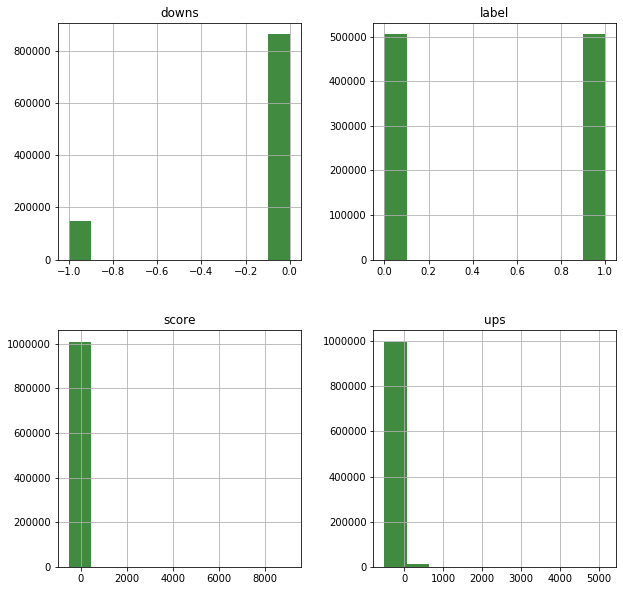

In [22]:
num_attributes.hist(figsize=(10,10), color = 'darkgreen', alpha = 0.75)
plt.show()

In [23]:
num_attributes.describe()

,label,score,ups,downs
count,1.010773e+06,1.010773e+06,1.010773e+06,1.010773e+06
mean,4.999817e-01,6.885999e+00,5.499140e+00,-1.458686e-01
std,5.000002e-01,4.834411e+01,4.127402e+01,3.529746e-01
min,0.000000e+00,-5.070000e+02,-5.070000e+02,-1.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00
75%,1.000000e+00,4.000000e+00,3.000000e+00,0.000000e+00
max,1.000000e+00,9.070000e+03,5.163000e+03,0.000000e+00


In [25]:
train_df.isnull().any()

label             False
comment           False
author            False
subreddit         False
score             False
ups               False
downs             False
date              False
created_utc       False
parent_comment    False
dtype: bool

In [33]:
# Creación de la Pipeline para númerico
num_pipeline = Pipeline(steps=[("num_attr_selector", ColumnsSelector(type='int64')), ("scaler", StandardScaler())])

In [36]:
cat_pipeline = Pipeline(steps=[("cat_attr_selector", ColumnsSelector(type=['object', 'bool'])), ("cat_imputer", CategoricalImputer()), ("encoder", CategoricalEncoder(dropFirst=True))])

In [38]:
num_pipeline.fit_transform(train_df)

array([[-0.9999634 , -0.10106715, -0.15746329, -2.41981135],
       [-0.9999634 , -0.22517746, -0.15746329, -2.41981135],
       [-0.9999634 , -0.08038209, -0.06054998,  0.41325536],
       ...,
       [ 1.00003661, -0.1217522 , -0.10900664,  0.41325536],
       [ 1.00003661, -0.1217522 , -0.10900664,  0.41325536],
       [ 1.00003661, -0.10106715, -0.08477831,  0.41325536]])

In [42]:
full_pipeline = FeatureUnion([("num_pipe", num_pipeline), ("cat_pipeline", cat_pipeline)])